### Understanding your data
<b>One Dimensional Data</b>

In [1]:
from typing import List,Dict
from collections import Counter
import math
import matplotlib.pyplot as plt


In [2]:
def bucketize(point:float, bucket_size:float) -> float:
    return bucket_size * math.floor(point/bucket_size)

In [3]:
def make_histogram(points: List[float], bucket_size: float) -> Dict[float,int]:
    return Counter(bucketize(point, bucket_size) for point in points)

In [4]:
def plot_histogram(points: List[float], bucket_size: float, title: str = ""):
    histogram = make_histogram(points, bucket_size)
    plt.bar(histogram.keys(), histogram.values(), width=bucket_size)
    plt.title(title)

In [5]:
def normal_cdf(x: float, mu: float = 0, sigma: float = 1) -> float:
    return (1 + math.erf((x - mu) / math.sqrt(2) / sigma)) / 2
def inverse_normal_cdf(p: float,
                       mu: float = 0,
                       sigma: float = 1,
                       tolerance: float = 0.00001) -> float:
    if mu != 0 or sigma != 1:
        return mu + sigma * inverse_normal_cdf(p, tolerance=tolerance)

    low_z = -10.0                      # normal_cdf(-10) is (very close to) 0
    hi_z  =  10.0                      # normal_cdf(10)  is (very close to) 1
    while hi_z - low_z > tolerance:
        mid_z = (low_z + hi_z) / 2     # Consider the midpoint
        mid_p = normal_cdf(mid_z)      # and the cdf's value there
        if mid_p < p:
            low_z = mid_z              # Midpoint too low, search above it
        else:
            hi_z = mid_z               # Midpoint too high, search below it

    return mid_z

In [6]:
import random
random.seed(0)
uniform = [200*random.random() - 100 for _ in range(10000)]
normal = [57 * inverse_normal_cdf(random.random())
         for _ in range(10000)]

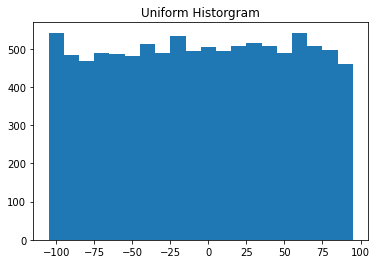

In [7]:
plot_histogram(uniform,10,'Uniform Historgram')

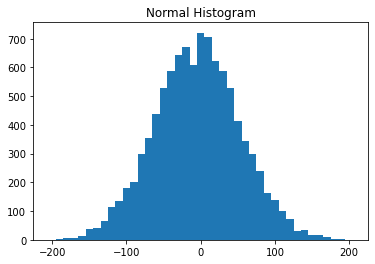

In [8]:
plot_histogram(normal, 10, "Normal Histogram")

<b>Two Dimensional Data</b>

In [9]:
def random_normal() -> float:
    return inverse_normal_cdf(random.random())

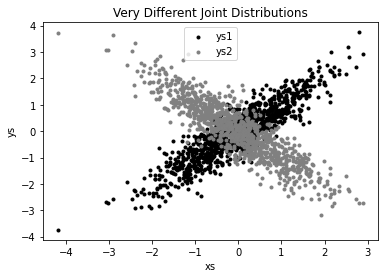

In [10]:
xs = [random_normal() for _ in range(1000)]
ys1 = [ x + random_normal() / 2 for x in xs]
ys2 = [ -x + random_normal() / 2 for x in xs]
plt.scatter(xs, ys1, marker='.', color='black', label='ys1')
plt.scatter(xs, ys2, marker='.', color='gray', label='ys2')
plt.xlabel('xs')
plt.ylabel('ys')
plt.legend(loc=9)
plt.title("Very Different Joint Distributions")
plt.show()

0.9010493686379609
-0.8920981526880033


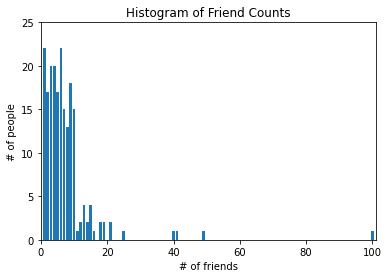

In [11]:
from scratch.statistics import correlation
print(correlation(xs,ys1))
print(correlation(xs,ys2))

In [12]:
from scratch.linear_algebra import Matrix, Vector, make_matrix
def correlation_matrix(data:List[Vector]) -> Matrix:
    def correlation_ij(i: int, j: int) -> float:
        return correlation(data[i], data[j])
    return make_matrix(len(data), len(data), correlation_ij)

In [14]:
num_vectors = len(corr_data)
fig, ax = plt.subplots(num_vectors, num_vectors)

for i in range(num_vectors):
    for j in range(num_vectors):
        
        if i != j: ax[i][j].scatter(corr_data[j], corr_data[i])
        else: ax[i][j].annotate("series " + str(i), (0.5, 0.5),
                                xycoords='axes fraction',
                                ha="center", va="center")
            
        if i < num_vectors - 1: ax[i][j].xaxis.set_visible(False)
        if j > 0: ax[i][j].yaxis.set_visible(False)
            
ax[-1][-1].set_xlim(ax[0][-1].get_xlim())
ax[0][0].set_ylim(ax[0][1].get_ylim())
plt.show()
# This will throw an error since we haven't defined 'corr_data'

NameError: name 'corr_data' is not defined

In [15]:
import datetime
stock_price = {'closing_price':102.06,
               'data':datetime.date(2014,8,29),
               'symbol':'AAPL'}

In [16]:
stock_price['cosing_prce'] = 103.06

In [17]:
prices: Dict[datetime.date,float] = {}

In [22]:
from typing import NamedTuple
class StockPrice(NamedTuple):
    symbol: str
    date: datetime.date
    closing_price: float
    def is_high_tech(self) -> bool:
        """It's a class, so we can add methods too"""
        return self.symbol in ['MSFT', 'GOOG', 'FB', 'AMZN', 'AAPL']
price = StockPrice('MSFT', datetime.date(2018, 12, 14), 106.03)
print(price)

StockPrice(symbol='MSFT', date=datetime.date(2018, 12, 14), closing_price=106.03)


<b>Dataclasses</b>

In [23]:
from dataclasses import dataclass
@dataclass
class StockPrice2:
    symbol: str
    date: datetime.date
    closing_price: float
    def is_high_tech(self) -> bool:
        """It's a class, so we can add methods too"""
        return self.symbol in ['MSFT', 'GOOG', 'FB', 'AMZN', 'AAPL']
price2 = StockPrice2('MSFT', datetime.date(2018, 12, 14), 106.03)
print(price2)

StockPrice2(symbol='MSFT', date=datetime.date(2018, 12, 14), closing_price=106.03)


<b>Cleaning and Munging</b>

In [25]:
from dateutil.parser import parse
def parse_row(row: List[str]) -> StockPrice:
    symbol, date, closing_price = row
    return StockPrice(symbol=symbol,
                        date=parse(date).date(),
                        closing_price=float(closing_price))
# Now test our function
stock = parse_row(["MSFT", "2018-12-14", "106.03"])
print(stock)

StockPrice(symbol='MSFT', date=datetime.date(2018, 12, 14), closing_price=106.03)


In [26]:
from typing import Optional
import re
def try_parse_row(row: List[str]) -> Optional[StockPrice]:
    symbol, date_, closing_price_ = row
    # Stock symbol should be all capital letters
    if not re.match(r"^[A-Z]+$", symbol):
        return None
    try:
        date = parse(date_).date()
    except ValueError:
        return None
    try:
        closing_price = float(closing_price_)
    except ValueError:
        return None
    return StockPrice(symbol, date, closing_price)

In [28]:
import csv
data: List[StockPrice] = []
with open("comma_delimited_stock_prices.csv") as f:
    reader = csv.reader(f)
    for row in reader:
        maybe_stock = try_parse_row(row)
        if maybe_stock is None:
            print(f"skipping invalid row: {row}")
        else:
            data.append(maybe_stock)

skipping invalid row: ['MSFT', '6/19/2014', 'n/a']
